In [53]:
# !pip install torchvision

** Image classifiaction using pytorch (Transfer learning) **

In [54]:
import torch
print(torch.__version__)

2.0.1+cpu


Import libraries

In [55]:
from pathlib import Path
import time
import random
import io
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as metrics
import torchvision
from torchvision.utils import make_grid
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import pickle
import os
import torch
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F


from torchvision.models import  resnet50, ResNet50_Weights
from PIL import Image
from torch.optim import Adam
import torch.optim as optim
from torch.nn import Linear, CrossEntropyLoss
import copy
from tqdm import tqdm

In [56]:
# import zipfile
# zip_ref=zipfile.ZipFile("Fruits Dataset.v2-raw.folder.zip")
# zip_ref.extractall()
# zip_ref.close()

In [57]:
data_path = Path('Fruits Dataset.v2-raw.folder/train')

Transform Images and convert to tensor:-

In [58]:
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [59]:
dataset = ImageFolder(data_path, transform = transformer)
print(dataset.classes)

['Tomato 3', 'Tomato 4', 'Tomato Cherry Red', 'Tomato Maroon', 'Tomato Yellow', 'Walnut']


In [60]:
for i in os.listdir(data_path):
  print("No of Images in ",i," class is ",len(os.listdir(os.path.join(data_path,i))))

No of Images in  Tomato 3  class is  267
No of Images in  Tomato 4  class is  368
No of Images in  Tomato Cherry Red  class is  382
No of Images in  Tomato Maroon  class is  257
No of Images in  Tomato Yellow  class is  349
No of Images in  Walnut  class is  625


Data Spiltting

In [61]:
test_size = int(.20 * len(dataset))
train_size = len(dataset) - test_size*2
train, test,val= torch.utils.data.random_split(dataset, [train_size,test_size,test_size])
print(f'split lengths: {(len(train),len(test),len(val))}')

split lengths: (1350, 449, 449)


In [62]:
img, label = train[100]
print(img.shape, label)

torch.Size([3, 224, 224]) 5


In [63]:
train_dl = DataLoader(dataset = train, batch_size = 30, shuffle=True, num_workers=4, pin_memory = True)
test_dl = DataLoader(dataset = test, batch_size = 10, num_workers=2, pin_memory = True)
val_dl = DataLoader(dataset = val, batch_size = 10, num_workers=2, pin_memory = True)

In [64]:
train_dl

In [65]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [66]:
def to_device(data, device):
  """move tensor(s) to current device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [67]:
class DeviceDataLoader():
  """wrap dataloader, then transfer to device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    """yield a batch of data after moving it to device"""
    for batch in self.dl:
      yield to_device(batch, self.device)
  def __len__(self):
    """number of batches"""
    return len(self.dl)

In [68]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

#### Explan :
 Here, DeviceDataLoader is a custom class or utility designed to wrap around PyTorch's DataLoader to move the data to a specified device (CPU or GPU).

In [69]:
len(test_dl)

45

In [70]:
LEN_TRAIN = len(train_dl)
LEN_TEST = len(test_dl)
LEN_VALID = len(val_dl)
print(LEN_TRAIN, LEN_TEST, LEN_VALID )

45 45 45


### Load the Resnet50 model

In [71]:
model = resnet50(pretrained=True)
model

c:\Users\s21\Desktop\my data\Computer Vision\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\s21\Desktop\my data\Computer Vision\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [72]:
in_features=model.fc.in_features
in_features

2048

#### Expaln :

The model.fc refers to the fully connected (fc) layer at the end of the ResNet-50 model. This line extracts the number of input features to this fully connected layer. In ResNet-50, the fully connected layer typically has an input size of 2048, which is the number of features output by the preceding layer.

In [73]:
model = model.to(device)

model.fc = Linear(in_features, out_features=6)
model.fc

Linear(in_features=2048, out_features=6, bias=True)

In [26]:
optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [27]:
loss_fn = CrossEntropyLoss()

In [28]:
best_acc=0.0
best_model_wts=copy.deepcopy(model.state_dict())
train_loss=[]
val_loss=[]
for epoch in range(1,5):
  start = time()
  train_acc = 0
  valid_acc = 0
  valid_loss=0.0
  training_loss=0.0
  model.train() #ets the model to training mode, which enables features like dropout and
  # batch normalization that are only applied during training.
  total1=0 # keep track of the total number of training samples processed during the epoch.
  with tqdm(train_dl, unit="batch") as tepoch: # Sets up a tqdm progress bar that will be used to
                                              # display the progress of the training loop.
    for xtrain, ytrain in tepoch:
      optimiser.zero_grad()                     #clears the gradients of all optimized tensors.
      xtrain = xtrain.to(device)
      train_prob = model(xtrain) # computes the output of the model for the current batch.
      loss = loss_fn(train_prob, ytrain)
      loss.backward() #computes the gradients of the loss with respect to the model parameters.
      optimiser.step() # updates the model parameters based on the computed gradients.
      training_loss+=loss.item()
      train_pred = torch.max(train_prob, 1).indices  #computes the predicted class for each training sample in the batch.
      total1+=ytrain.size(0)
      train_acc += int(torch.sum(train_pred == ytrain))
    ep_tr_acc = train_acc / total1 # computes the accuracy of the model on the training set
    a=training_loss/LEN_TRAIN  #calculates the training loss per sample for the epoch, and stores it in a
                                # list of training losses.
    train_loss.append(a)
  model.eval()  #sets the model to evaluation mode, which disables features like dropout and batch
                #  normalization that are only applied during training.
  total=0 # initializes a variable to keep track of the total number of validation samples processed during the epoch.
  with torch.no_grad(): #disables gradient computation, since we're only evaluating the model and not updating its parameters.
    for xvalid, yvalid in val_dl:
      xvalid = xvalid.to(device)
      valid_prob = model(xvalid)
      loss = loss_fn(valid_prob, yvalid)
      valid_loss+=loss.item()
      valid_pred = torch.max(valid_prob,1).indices
      total+=yvalid.size(0)
      valid_acc += int(torch.sum(valid_pred == yvalid))
    ep_valid_acc = valid_acc / total
    val_loss.append(valid_loss/LEN_VALID)
    if ep_valid_acc > best_acc:
      best_acc = ep_valid_acc
      best_model_wts = copy.deepcopy(model.state_dict())  # creates a deep copy of the state dictionary of a PyTorch model and
  end = time()                                            # assigns it to the variable best_model_wts.
  duration = (end - start) / 60
  print(f"Epoch: {epoch}, Time: {duration} \ntrain_loss:{training_loss/LEN_TRAIN} ,val_loss:{valid_loss/LEN_VALID}\nTrain_acc: {ep_tr_acc}, Valid_acc: {ep_valid_acc}")

100%|██████████| 45/45 [03:08<00:00,  4.20s/batch]


Epoch: 1, Time: 3.5560752908388773 
train_loss:0.6694163125422266 ,val_loss:0.0391316208574507
Train_acc: 0.8096296296296296, Valid_acc: 1.0


100%|██████████| 45/45 [03:05<00:00,  4.12s/batch]


Epoch: 2, Time: 3.4980587085088093 
train_loss:0.032883762361274826 ,val_loss:0.006803551730182436
Train_acc: 0.9992592592592593, Valid_acc: 1.0


100%|██████████| 45/45 [03:06<00:00,  4.15s/batch]


Epoch: 3, Time: 3.513182592391968 
train_loss:0.01940557808201346 ,val_loss:0.0035981247356782356
Train_acc: 0.9992592592592593, Valid_acc: 1.0


100%|██████████| 45/45 [03:04<00:00,  4.10s/batch]


Epoch: 4, Time: 3.476743257045746 
train_loss:0.009426100924611092 ,val_loss:0.002571589815326863
Train_acc: 1.0, Valid_acc: 1.0


Visualization(Train loss vs Valid loss) epochs vs loss

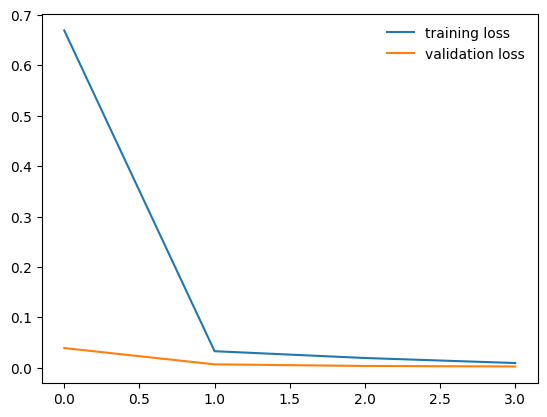

In [29]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label = "training loss")
plt.plot(val_loss, label = "validation loss")
plt.legend(frameon = False)

Save the model

In [30]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [31]:
torch.save(model.state_dict(),'Best_Model15')

#### Load the trained model

In [32]:
model.load_state_dict(torch.load('Best_Model15',map_location=torch.device('cpu')))


<All keys matched successfully>

In [33]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_best1510.pt')

In [42]:
model_best=torch.jit.load('model_best1510.pt')

Display Prdiction on test data

In [34]:
# helper function to predict on dataloader images
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model_best(xb) # get predictions from model
  prob, preds  = torch.max(yb, dim=1)
  return dataset.classes[preds[0].item()]   # return s the class labele from dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Label: Tomato 3 , Predicted: Tomato 3


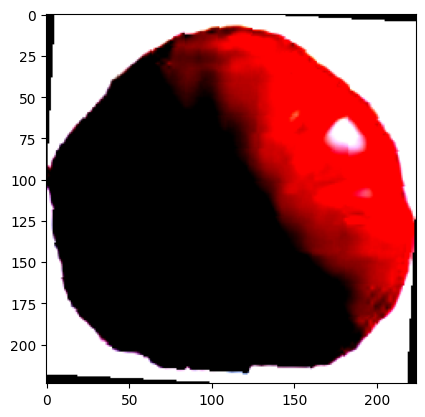

In [52]:
img, label = test[66]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))